# Ford Go Bike 2017
## by Marcello Victorino
*06/2019*

## Dataset

The Ford Go Bike is the Bike-share system operating in the Bay Area, San Francisco (USA). With around 6.400 bikes in more than 360 stations across San Francisco, East Bay and San Jose, there are basically two types of subscription:

1. **Subscriber**: Membership can be Monthly (\$15/mo) or Annual (\$150/yr, equivalent to \$12.50/mo). It grants unlimited 45-minutes trips
2. **Customer**: 
   + Single ride (\$2 per trip) and 
   + Access Pass (\$10), granting unlimited 30-minute rides within 24 hours.

The [dataset](<https://www.fordgobike.com/system-data>) is open to the public, containing station and user data for each trip. At the time of this project, is was possible to download historic data from June, 2017 up to April, 2019.

The raw data was spread out into 17 files. After appending all into a single data frame, I performed some Data Wrangling, summarized in the following:

## Data Wrangling
+ **Missing values**: there were around 220 thousand observations missing data for user gender and birth year. Instead of applying imputation techniques (median and mode for numerical and categorical variables, respectively), I decided to drop these rows.
+ **Bike Share For All Trip**: this variable is not present in the 2017 data. I filled all 2017 missing data as 'No', since the special pricing program for qualifying low-income users in the Bay area wasn't in place at the time.
+ **Station Data:** to improve performance, I created a new table holding unique values for the station ID and their name, removing the Start and End station name from the main dataset. It is possible to retrieve this information afterward by merging the data on the unique station ID.
+ **Data Type**: 
  + 'station_id' stored as string instead of float
  + 'member birth year' stored as integer instead of float
  + end and start time stored as date-time

## Feature Engineering

After dealing with data integrity issues, I transformed some variables into a more meaningful format and extracted the components of the start time variable:

+ Transformed member gender into binary variable, where 1: Male, 0: Female.
+ Transformed User Type into binary, where 1:Subscriber (Annual Pass), 0: Customer (Single Ride or Access Pass)
+ Transformed Low Income Trip into binary, where 1: Yes, 0: No.
+ Transformed trip duration from seconds to minutes.
+ Calculated user age at time of bike rental.
+ Extracted from Start Time of rental: year, month, week, day, day of week, and hour

After this process, the final dataset has over 3 million observations with 19 columns, containing information over the initial and final bike station, time of start of the trip, duration in minutes; as well as details over the user, such as gender, age, and member status (subscriber or not).

## Limitation
Since this project was developed using a remote access based on Github, the maximum file size restriction imposed a limitation to the dataset to be analyzed. Therefore, the Exploratory Data Analysis step developed below is limited only to the 2017 available data (from June to December).

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load the data
df = pd.read_csv('Clean_FordGoBike_2017.csv')
df.head()

bike_id  end_station_id  end_station_latitude  end_station_longitude  \
0       96              43             37.778768            -122.415929   
1       88              96             37.766210            -122.426614   
2     3167             247             37.867789            -122.265896   
3     3539             259             37.866249            -122.299371   
4     2311              24             37.789677            -122.390428   

   start_station_id  start_station_latitude  start_station_longitude  \
0                74               37.776435              -122.426244   
1               284               37.784872              -122.400876   
2               239               37.868813              -122.258764   
3               259               37.866249              -122.299371   
4                67               37.776639              -122.395526   

                start_time  low_income_trip  subscriber  gender  duration_min  \
0  2017-12-31 16:57:39.654                0           0       1        1335.2   
1  2017-12-31 15:56:34.842                0           0       0        1313.3   
2  2017-12-31 14:23:14.001                0           1       0         726.7   
3  2017-12-31 23:49:28.422                0           0       0          75.1   
4  2017-12-31 23:52:55.581                0           1       1          36.4   

   user_age  year  month  week  day  weekday  hour  
0        31  2017     12    52   31        6    16  
1        53  2017     12    52   31        6    15  
2        21  2017     12    52   31        6    14  
3        27  2017     12    52   31        6    23  
4        28  2017     12    52   31        6    23

Since the data has already been wrangled, we can now start working on the Exploratory Data Analysis, tackling it in a procedural manner:
1. **Dataset Structure**: Integrity Check, no missing data, no duplicates, appropriate data types etc.
2. **Univariate Analysis**: investigate each variable distribution, flagging possible outliers and/or need for transformations
3. **Correlation Matrix**: identify pair of variables highly correlated ($Pearson's R \geq 0.70$)
4. **Bivariate Analysis**: investigate pair-wise relationship among variables to identify interesting - and possibly not so obvious - patterns
5. **Multivariate Analysis**: investigate pair-wise relationship against one (or more) main variable of interest

Once completed, we should be able to uncover some interesting insights worth sharing with others.

This process requires some final polishing to make sure our visualization has the appropriate encodings and convey the message we want to communicate.

## Dataset Structure

In [3]:
df.shape

(453159, 19)

The dataset contains over 3 million rows and 19 columns, of which: 
+ 8 are numerical
+ 3 are string/nominal
+ 4 are positional (lat/long)
+ 3 are categorical (binary)
+ 1 is datetime

In [4]:
# Strings
to_string = ['bike_id', 'end_station_id', 'start_station_id']
for col in to_string:
    df[f'{col}'] = df[f'{col}'].astype(str)

# Date-time
df.start_time = pd.to_datetime(df.start_time)

For efficiency purpose, since we are only working with small numbers, let's also transform the numerical variables into their lighter version:

In [5]:
# Float 32
to_float32 = ['end_station_latitude', 'end_station_longitude', 'start_station_latitude', 'start_station_longitude', 'duration_min']
for col in to_float32:
    df[f'{col}'] = df[f'{col}'].astype(np.float32)
    
# Integer32
to_int = ['low_income_trip', 'subscriber', 'gender', 'user_age', 'year', 'month', 'week', 'day', 'weekday', 'hour']
for col in to_int:
    df[f'{col}'] = df[f'{col}'].astype(np.int32)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453159 entries, 0 to 453158
Data columns (total 19 columns):
bike_id                    453159 non-null object
end_station_id             453159 non-null object
end_station_latitude       453159 non-null float32
end_station_longitude      453159 non-null float32
start_station_id           453159 non-null object
start_station_latitude     453159 non-null float32
start_station_longitude    453159 non-null float32
start_time                 453159 non-null datetime64[ns]
low_income_trip            453159 non-null int32
subscriber                 453159 non-null int32
gender                     453159 non-null int32
duration_min               453159 non-null float32
user_age                   453159 non-null int32
year                       453159 non-null int32
month                      453159 non-null int32
week                       453159 non-null int32
day                        453159 non-null int32
weekday                    453159 

In [7]:
df.isnull().sum()

bike_id                    0
end_station_id             0
end_station_latitude       0
end_station_longitude      0
start_station_id           0
start_station_latitude     0
start_station_longitude    0
start_time                 0
low_income_trip            0
subscriber                 0
gender                     0
duration_min               0
user_age                   0
year                       0
month                      0
week                       0
day                        0
weekday                    0
hour                       0
dtype: int64

In [8]:
df.duplicated().sum()

0

There are no duplicates or missing values.

Let's perform some sanity check on the values:

In [9]:
pd.options.display.float_format = '{:,.2f}'.format
df.describe()

end_station_latitude  end_station_longitude  start_station_latitude  \
count            453,159.00             453,159.00              453,159.00   
mean                  37.77                -122.36                   37.77   
std                    0.08                   0.10                    0.08   
min                   37.32                -122.44                   37.32   
25%                   37.77                -122.41                   37.77   
50%                   37.78                -122.40                   37.78   
75%                   37.80                -122.39                   37.80   
max                   37.88                -121.87                   37.88   

       start_station_longitude  low_income_trip  subscriber     gender  \
count               453,159.00       453,159.00  453,159.00 453,159.00   
mean                   -122.36             0.00        0.89       0.77   
std                       0.10             0.00        0.31       0.42   
min                    -122.44             0.00        0.00       0.00   
25%                    -122.41             0.00        1.00       1.00   
50%                    -122.40             0.00        1.00       1.00   
75%                    -122.39             0.00        1.00       1.00   
max                    -121.87             0.00        1.00       1.00   

       duration_min   user_age       year      month       week        day  \
count    453,159.00 453,159.00 453,159.00 453,159.00 453,159.00 453,159.00   
mean          13.88      36.60   2,017.00       9.78      40.68      15.87   
std           42.09      10.51       0.00       1.56       6.70       8.81   
min            1.00      18.00   2,017.00       6.00      26.00       1.00   
25%            6.10      29.00   2,017.00       9.00      35.00       8.00   
50%            9.30      34.00   2,017.00      10.00      41.00      16.00   
75%           14.00      43.00   2,017.00      11.00      46.00      23.00   
max        1,437.50     131.00   2,017.00      12.00      52.00      31.00   

         weekday       hour  
count 453,159.00 453,159.00  
mean        2.52      13.39  
std         1.80       4.67  
min         0.00       0.00  
25%         1.00       9.00  
50%         2.00      14.00  
75%         4.00      17.00  
max         6.00      23.00

+ All pairs of latitude and longitude seem coherent with the San Francisco area.
+ Since we are working only with 2017 data, there is no information for Low Income Trip. Let's drop this column.
+ Subscriber and Gender: these features represent binary data. All values are between 0 and 1.
+ User Age: Minimum value is 18 years old - which might be a requirement to register and use the system. But the maximum value of 131 years old seems off and require further investigation.
+ Trip Duration: Minimum value is 1, probably representing a user that got a bike and decided to swap it for a different one. The maximum value is 1,437, representing almost a full day. Let's further investigate these extreme low/high values
+ Month: Minimum value is 6 and maximum is 12, meaning there is data from June - December of 2017.
+ All other date components fields are appropriate

In [10]:
# Drop Low Income Trip column
df.drop(columns='low_income_trip', inplace=True)

In [11]:
# Further investigate maximum user age
print(f"Total of {df.query('user_age > 100').user_age.count()} trips by user > 100 years old")

df.query('user_age > 100').user_age.value_counts()

Total of 384 trips by user > 100 years old


115    217
117    142
106     12
110      7
116      4
131      2
Name: user_age, dtype: int64

Since there are only few records for trips taken by users older than 100 years old, let's go ahead and remove such observations:

In [12]:
df.drop(df.query('user_age > 100').index, inplace=True)

In [13]:
# Trip Duration: investigating extreme values
df.query('duration_min < 2').count()[0]/len(df)

0.0091303627629617367

Less than 1% of trips last less than 2 minutes. They probably represent a malfunctioning bicycle that need to be swapped.
Let's go ahead and remove these trips:

In [14]:
df = df.query('duration_min >= 2')

In [15]:
# Proportion of trips lasting under 60 minutes
proportion_under60 = df.query('duration_min <= 60').count()[0]/len(df)
print(f'{proportion_under60:.1%} of trips last less than 60 minutes.')

98.8% of trips last less than 60 minutes.


Since the vast majority of trips (98.8%) don't last longer than one hour, let's go ahead and keep only observations between 2 and 60 minutes of trip duration:

In [16]:
df = df.query('duration_min >= 2 & duration_min <= 60')

Finally, let's use the datetime variable as the index, allowing us to make use of the powerful time-series functions provided by Pandas:

In [17]:
df.set_index(df.start_time, inplace=True)

In [18]:
df.sort_index(inplace=True)
df.head()

bike_id end_station_id  end_station_latitude  \
start_time                                                             
2017-06-28 09:47:36.347     240             48                 37.78   
2017-06-28 09:47:41.664     669             59                 37.77   
2017-06-28 09:49:46.377     117             48                 37.78   
2017-06-28 09:50:59.175      77              9                 37.80   
2017-06-28 09:56:39.631     316            321                 37.78   

                         end_station_longitude start_station_id  \
start_time                                                        
2017-06-28 09:47:36.347                -122.39               21   
2017-06-28 09:47:41.664                -122.42               58   
2017-06-28 09:49:46.377                -122.39               25   
2017-06-28 09:50:59.175                -122.40               81   
2017-06-28 09:56:39.631                -122.40               66   

                         start_station_latitude  start_station_longitude  \
start_time                                                                 
2017-06-28 09:47:36.347                   37.79                  -122.40   
2017-06-28 09:47:41.664                   37.78                  -122.42   
2017-06-28 09:49:46.377                   37.79                  -122.40   
2017-06-28 09:50:59.175                   37.78                  -122.39   
2017-06-28 09:56:39.631                   37.78                  -122.39   

                                     start_time  subscriber  gender  \
start_time                                                            
2017-06-28 09:47:36.347 2017-06-28 09:47:36.347           1       0   
2017-06-28 09:47:41.664 2017-06-28 09:47:41.664           1       1   
2017-06-28 09:49:46.377 2017-06-28 09:49:46.377           1       1   
2017-06-28 09:50:59.175 2017-06-28 09:50:59.175           1       1   
2017-06-28 09:56:39.631 2017-06-28 09:56:39.631           1       1   

                         duration_min  user_age  year  month  week  day  \
start_time                                                                
2017-06-28 09:47:36.347          7.10        32  2017      6    26   28   
2017-06-28 09:47:41.664          6.10        36  2017      6    26   28   
2017-06-28 09:49:46.377          3.10        33  2017      6    26   28   
2017-06-28 09:50:59.175         20.00        32  2017      6    26   28   
2017-06-28 09:56:39.631          7.20        44  2017      6    26   28   

                         weekday  hour  
start_time                              
2017-06-28 09:47:36.347        2     9  
2017-06-28 09:47:41.664        2     9  
2017-06-28 09:49:46.377        2     9  
2017-06-28 09:50:59.175        2     9  
2017-06-28 09:56:39.631        2     9

## Univariate Exploration
Let's start the investigation at the individual level. This step allows us to identify basic descriptive information, as well as unusual values that might be worth further investigating (outliers).

In [19]:
def proportion_categorical(variable, **kwargs):
    g = df[f'{variable}'].value_counts(normalize=True)
    sns.barplot(x=g.keys(), y=g.values, **kwargs)
    plt.title(f'Proportion of {str.title(variable)}')
    plt.ylabel('Proportion [%]');
    [print(f'Category {x[0]}: {x[1]:.1%}') for x in g.items()];

Category 1: 89.8%
Category 0: 10.2%


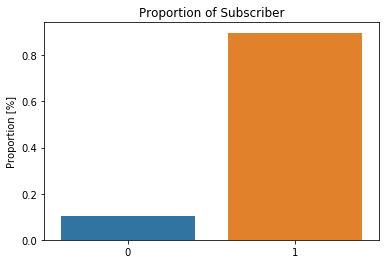

In [20]:
proportion_categorical('subscriber')

Almost 90% of trips were taken by actual subscribers to the Ford Go Bike program.

Category 1: 77.0%
Category 0: 23.0%


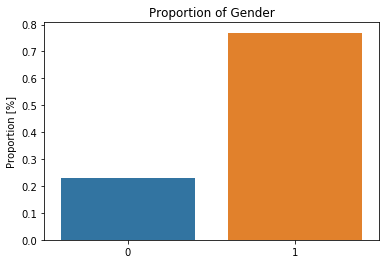

In [21]:
proportion_categorical('gender')

And 77% of the trips were taken by males. 

Since we do not have access to the actual distribution of subscribers, we cannot tell if males are more likely to use the bike-rental program or if this higher frequency of trips is due to having more male subscribers.

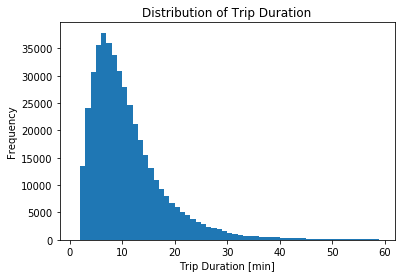

In [22]:
df.query('duration_min <= 60').duration_min.plot(kind='hist', bins=range(1,60,1));
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration [min]');

The trip distribution (in minutes) is highly skewed to the right, even after filtering out trips taking longer than one hour.

Let's transform it into the log10 scale:

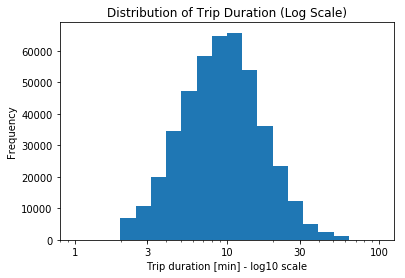

In [23]:
log_bins = 10 ** np.arange(0, 2+0.1, 0.1)

df.query('duration_min <= 60').duration_min.plot(kind='hist', bins=log_bins);
plt.xscale('log')
log_ticks = [1, 3, 10, 30, 100]
plt.xticks(log_ticks, log_ticks)
plt.xlabel('Trip duration [min] - log10 scale')
plt.title('Distribution of Trip Duration (Log Scale)');

After transforming the trip duration (min) into the log10 scale, the values present a normal-like distribution. 

In [24]:
print(df.duration_min.quantile(0.975),'\n')

print(df.duration_min.describe())

29.7999992371 

count   443,121.00
mean         11.03
std           7.23
min           2.00
25%           6.10
50%           9.20
75%          13.80
max          60.00
Name: duration_min, dtype: float64


97.5% of all trips lasts less than 30 minutes.

**The average trip duration is 11 minutes.**

Considering the average speed of a bicycle as 15 km/h, which is equivalent to 250 meters per minute, it means within 11 minutes, **the average trip usually travels 2.75 km.**

Tukeys Fence: upper threshold is 22.6


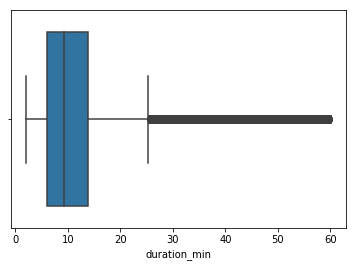

In [25]:
# Outlier: Tuke's Fence method .:. 1.5 * IQR
IQR = df.duration_min.quantile(0.75) - df.duration_min.quantile(0.25)
print(f'Tukeys Fence: upper threshold is {df.duration_min.mean() + 1.5 * IQR:.1f}')

sns.boxplot(df.duration_min);

According to the Tukey's Fence method, any trip lasting longer than 22.5 minutes is considered an outlier. This can be seen in the boxplot above.

Even though the values are extreme when compared to the vast majority of trips, it does not necessarily mean they are invalid observations. In this partiuclar case, we should not remove them.

61.0 

count   443,121.00
mean         36.55
std          10.25
min          18.00
25%          29.00
50%          34.00
75%          43.00
max          93.00
Name: user_age, dtype: float64


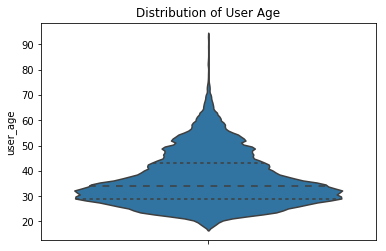

In [26]:
# Investigate User Age distribution
print(df.user_age.quantile(0.975),'\n')

print(df.user_age.describe())

sns.violinplot(df.user_age, inner='quartile', orient='v')
plt.title('Distribution of User Age');

Looking at the distribution of user age, 97.5% have less than 61 years old. In fact, the vast majority of users is composed of mid-age adults,between 30 and 45 years old.

Category 10: 21.1%
Category 11: 19.0%
Category 9: 18.8%
Category 12: 17.3%
Category 8: 15.4%
Category 7: 7.9%
Category 6: 0.5%


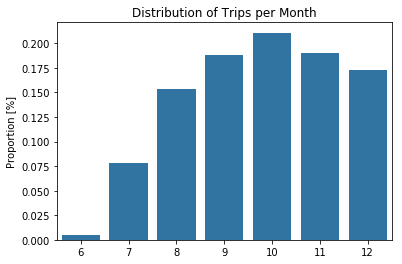

In [27]:
# Investigate Month distribution
proportion_categorical('month', color=sns.color_palette()[0])
plt.title('Distribution of Trips per Month');

For the data available (2017 June - December), looks like there is an uptrend peaking in October (21% of trips), where it then reverts to a downtrend, reaching 17% in December.

It seems strange that June has only 0.5% of trips. Perhaps there isn't data for the whole month. Let's further investigate this:

In [28]:
df.query('month == 6').day.unique()

array([28, 29, 30], dtype=int64)

Our suspicion hold true. The dataset only contains three days worth of data for the month of June, from 28 through 30. There is no need to drop data from this month, but it is important to bear this fact in mind during posterior analysis.

Category 1: 17.8%
Category 2: 17.8%
Category 3: 17.1%
Category 0: 16.3%
Category 4: 15.9%
Category 5: 8.0%
Category 6: 7.1%


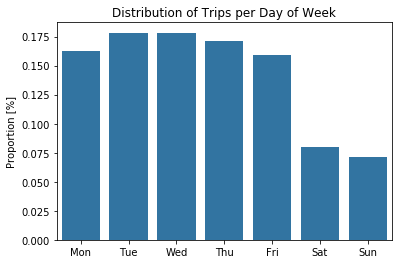

In [29]:
# Investigate Weekday distribution | 0 = Mon ; 6 = Sun
proportion_categorical('weekday', color=sns.color_palette()[0])
plt.title('Distribution of Trips per Day of Week')
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

Category 0: 84.9%
Category 1: 15.1%


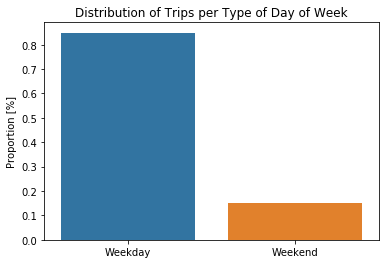

In [30]:
df['weekend'] = np.where(df.weekday >= 5,1,0)
proportion_categorical('weekend')
plt.title('Distribution of Trips per Type of Day of Week')
plt.xticks([0,1],['Weekday', 'Weekend']);

## INSIGHT
Surprisingly, the weekends actually have significantly less trips (around 7.5%), whereas the weekdays are pretty much uniformly distributed (around 17%).

This pattern leads us to believe the majority of trips are actually for commuting purposes.

Category 8: 12.2%
Category 17: 12.1%
Category 9: 9.4%
Category 18: 9.3%
Category 16: 7.9%
Category 7: 5.7%
Category 19: 5.2%
Category 15: 4.9%
Category 12: 4.7%
Category 13: 4.6%
Category 10: 4.6%
Category 11: 4.2%
Category 14: 4.1%
Category 20: 3.2%
Category 21: 2.3%
Category 6: 1.9%
Category 22: 1.5%
Category 23: 0.9%
Category 0: 0.5%
Category 5: 0.4%
Category 1: 0.2%
Category 4: 0.1%
Category 2: 0.1%
Category 3: 0.1%


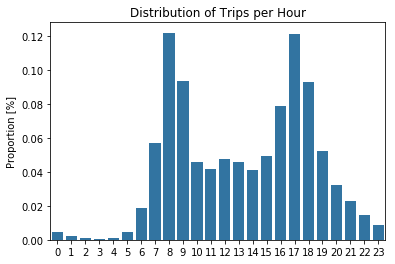

In [31]:
# Investigate Hour distribution
proportion_categorical('hour', color=sns.color_palette()[0])
plt.title('Distribution of Trips per Hour');

The plot of the distribution of trips along the hours of the day show the classic commute pattern, suporting our previous finding from the Day of Week analysis.

There is a clear peak of usage around 8h and 17h, depicting the typical pattern of home-work and then work-home trips.

Let's further investigate if this distribution changes between Weekdays and Weekends:

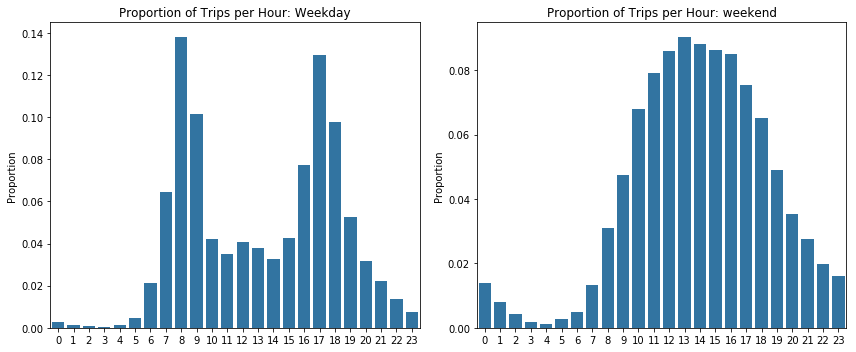

In [32]:
plt.figure(figsize=(12,5))

plt.subplot(121)
weekday = df.query('weekday not in (5,6)')
weekday_hours = weekday.hour.value_counts(normalize=True)
sns.barplot(x= weekday_hours.keys(), y= weekday_hours.values, color=sns.color_palette()[0])

plt.title(f'Proportion of Trips per Hour: Weekday')
plt.ylabel('Proportion');
# [print(f'Category {x[0]}: {x[1]:.1%}') for x in g.items()];

plt.subplot(122)
weekend = df.query('weekday in (5,6)')
weekend_hours = weekend.hour.value_counts(normalize=True)
sns.barplot(x= weekend_hours.keys(), y= weekend_hours.values, color=sns.color_palette()[0])

plt.title(f'Proportion of Trips per Hour: weekend')
plt.ylabel('Proportion');

plt.tight_layout()

## INSIGHT
It is possible to see an even clearer commuter pattern for trips occurring during weekdays.

During the weekends, the trips slowly increase starting at 8h, reaching its peak between 12h and 16h. Afterwards, they slightly decrease until 2h in the morning of the next day.

It seems weekend trips are typically taken for entertainment purpose, possible by tourists and people enjoying the city. It would be interesting to compare the duration against the time a trip was taken.

Some people are actually using the bike-share system during late hours in the weekends.

## Bivariate Exploration

After exploring the ditributin of individual variables, it is time to investigate a little bit deeper the relationship between them. In particular, let us focus on the most interesting features identified in the previous section:
+ Suscriber
+ Gender
+ Trip Duration
+ User Age
+ Day of Week
+ Hour of Trip

In [33]:
variables_interest = ['subscriber', 'gender','duration_min', 'user_age', 'weekday','hour']

In [34]:
df2 = df[variables_interest]
df2.head()

subscriber  gender  duration_min  user_age  weekday  \
start_time                                                                     
2017-06-28 09:47:36.347           1       0          7.10        32        2   
2017-06-28 09:47:41.664           1       1          6.10        36        2   
2017-06-28 09:49:46.377           1       1          3.10        33        2   
2017-06-28 09:50:59.175           1       1         20.00        32        2   
2017-06-28 09:56:39.631           1       1          7.20        44        2   

                         hour  
start_time                     
2017-06-28 09:47:36.347     9  
2017-06-28 09:47:41.664     9  
2017-06-28 09:49:46.377     9  
2017-06-28 09:50:59.175     9  
2017-06-28 09:56:39.631     9

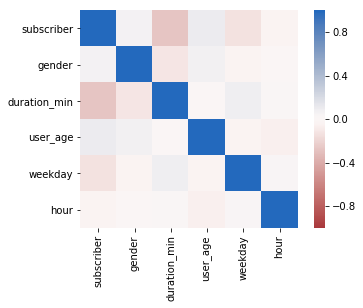

In [35]:
# Correlation Heatmap - Pearson R
sns.heatmap(df2.corr(), vmin=-1, vmax=1, cmap='vlag_r', square=True);

In [36]:
df2.corr()

subscriber  gender  duration_min  user_age  weekday  hour
subscriber          1.00    0.07         -0.27      0.11    -0.13 -0.04
gender              0.07    1.00         -0.11      0.07    -0.04  0.01
duration_min       -0.27   -0.11          1.00      0.00     0.09  0.02
user_age            0.11    0.07          0.00      1.00    -0.04 -0.06
weekday            -0.13   -0.04          0.09     -0.04     1.00  0.04
hour               -0.04    0.01          0.02     -0.06     0.04  1.00

Looks like there is little to no correlation between the variables, with the exception of Subscriber and Trip Duration - which shows a weak negative correlation, around $R = -0.3$. Suggesting that Subscribers (value 1) tend to use the bike for shorter trips. 

Since thre were no strong correlation identified, let´s systematically investigate the relationship between the features and the main variable of interest: Trip Duration.

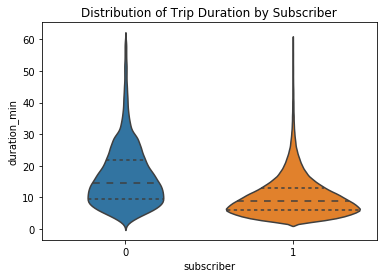

In [37]:
# Trip Duration vs Subscriber
sns.violinplot(data=df2, y='duration_min', x='subscriber', orient='v', inner='quartile');
plt.title('Distribution of Trip Duration by Subscriber');

### INSIGHT
There is a clear difference in the distribution of trip duration between subscribers and sporadic users. The former tends to take shorter trips, concentrated around 10 minutes. Whereas the latter is more spread out, with an average of about 15 minutes, going from 10 to 30 minutes, indicating longer trips. 

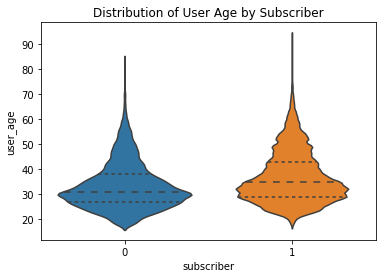

In [38]:
# User Age vs Subscriber
sns.violinplot(data=df2, y='user_age', x='subscriber', orient='v', inner='quartile');
plt.title('Distribution of User Age by Subscriber');

### INSIGHT
Sporadic users are generally younger, concentrated between 25 and 35 years old. Whereas subscribers are more spread out and typically older, going from 25 up to 45 years old, having many users between 50 and 60 years.

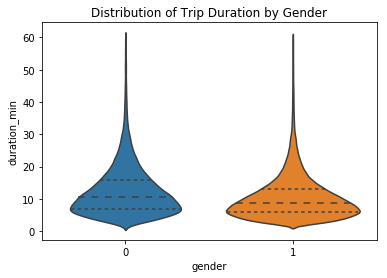

In [39]:
# Trip Duration vs Gender
sns.violinplot(data=df2, y='duration_min', x='gender', orient='v', inner='quartile');
plt.title('Distribution of Trip Duration by Gender');

In general, it looks like women tend to ride for a litle bit longer than men. But there is no clear difference of trip duration based on gender, having both male and female trip averaging around 10 minutes.

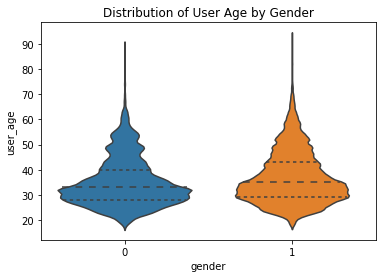

In [40]:
# User Age vs Gender
sns.violinplot(data=df2, y='user_age', x='gender', orient='v', inner='quartile');
plt.title('Distribution of User Age by Gender');

The median age is around 35 years old for both man and woman. Hence, there is no significant influence of gender on user age distribution.

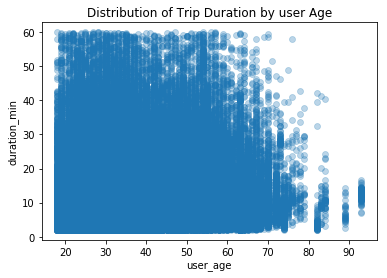

In [41]:
# Trip Duration vs Age
sns.scatterplot(data=df2, y='duration_min', x='user_age', alpha=0.3, edgecolor=None)
plt.title('Distribution of Trip Duration by user Age');

Since the scatter plot is too cluttered, let's visualize it as a heatmap instead:

In [42]:
df3 = df2.query('user_age <60 & duration_min < 30')

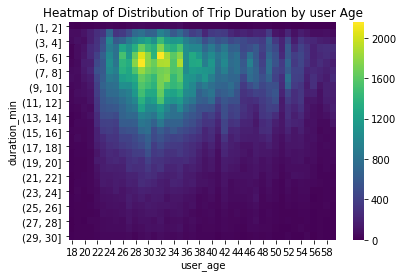

In [43]:
# Trip duration vs User ge - count
trip_duration_bins = pd.cut(df3.duration_min, bins=range(0,61))
sns.heatmap(df3.pivot_table(index=trip_duration_bins, columns=df3.user_age, aggfunc='count', fill_value=0).gender, vmin=0,
           cmap='viridis');
plt.title('Heatmap of Distribution of Trip Duration by user Age');

### INSIGHT
The majority of trips seems to be concentrated amongst users between 25 and 35 years old, riding from 5 to 10 minutes.

In addition, it looks like the majority of longer trips (greater than 15 minutes) are completed by users between 28 and 34 years old.

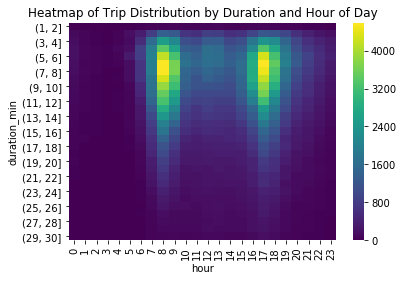

In [44]:
# Trip Duration vs Hour of day

sns.heatmap(df3.pivot_table(index=pd.cut(df3.duration_min, bins=range(0,61)),
                                columns=df3.hour, aggfunc='count',
                                fill_value=0).gender, vmin=0,cmap='viridis');
plt.title('Heatmap of Trip Distribution by Duration and Hour of Day');

As seen before, most trips occurs in two peaks (around 8h and 17h). But this heatmap shows they usually take between 5 and 10 minutes, suggesting really short trips.

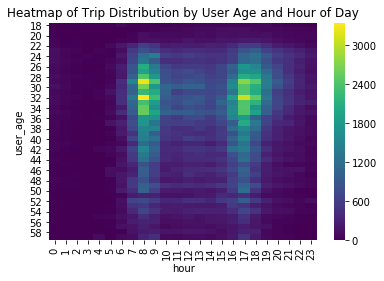

In [45]:
# User Age vs Hour of day
sns.heatmap(df3.pivot_table(index=df3.user_age, columns=df3.hour, aggfunc='count', fill_value=0).gender,
            vmin=0,cmap='viridis');
plt.title('Heatmap of Trip Distribution by User Age and Hour of Day');

There is no clear correlation between user age and the time the trip occurs.

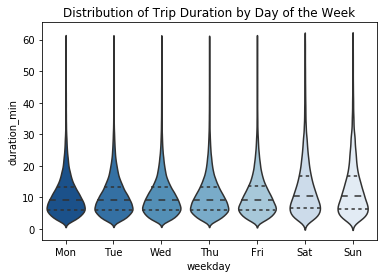

In [46]:
# Trip Duration vs Day of Week
sns.violinplot(data=df2, y='duration_min', x='weekday', orient='v', inner='quartile', palette='Blues_r');
plt.title('Distribution of Trip Duration by Day of the Week');
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

There is no clear difference of trip duration dristribution based on the day of the week. Weekend trips (Sat and Sun) seems to be slightly longer and more spread out than the typical weekday.

This reinforces the pattern previously identified, where trips taken during weekdays are shorter - suggesting commutte purpose. Whereas in the weekend they are slightly longer, having more people using the bikes to explore the city.

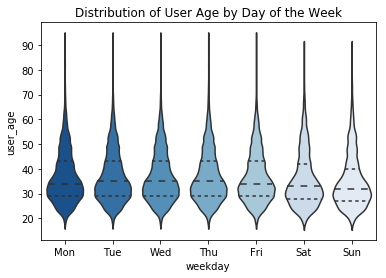

In [47]:
# User Age vs Day of Week
sns.violinplot(data=df2, y='user_age', x='weekday', orient='v', inner='quartile', palette='Blues_r');
plt.title('Distribution of User Age by Day of the Week');
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

There is no relationship between user age and day of week a trip is taken.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Considering Trip Duration as the main variable of interest, it was possible to identify interesting relationships with:
+ **Subscriber** status: even though subscribers have access to unlimited 45-minutes rides, their trips are typically shorter, concentrated around 10 minutes. Whereas sporadic users trip duration is more spread out, averaging around 15 minutes, going from 10 to 30 minutes, indicating longer trips. 

+ **Gender**: no significant impact over trip duration.
+ **User Age**: no clear correlation, suggesting the physical effort of riding the bike is not a limiting factor.
+ **Hour of Day**: the vast majority of trips are concentrated in two peaks, around 8h and 17h, suggesting a typical commuting pattern
+ **Day of Week**: although not significantly different, it is possible to see a difference in trip duration depending on the day of the week, having shorter duration during weekdays and slightly longer during the weekend.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

There was no significant relationship identified between the other features.

## Multivariate Exploration
Now it is time to dig even deeper into the interesting relationship identified in the bivarite analysis step:
+ Trip Duration
+ Subscriber
+ Gender
+ User Age
+ Weekday/Weekend

Let's further investigate the distribution of trip duration, stratifying by gender and subscriber:

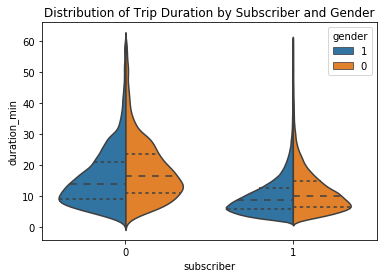

In [48]:
# Trip Duration vs Subscriber vs Gender
sns.violinplot(data=df, y='duration_min', x='subscriber', hue='gender', split=True, orient='v', inner='quartile',
              hue_order=[1,0]);
plt.title('Distribution of Trip Duration by Subscriber and Gender');

### INSIGHT
Even though subscribers have access to unlimited 45-minutes trips, looks like their trips are typically shorter than Non-subscribers. 

This could be explained due to the fact that subscribers usually take the bike for mobility purpose (trip as a mean of transportation), whereas occasional users could represent tourists using the bike for leisure and getting to know the city.

Although not a significant difference, females seems to ride for slightly longer duration than males, for both subscribers and non-subscribers.

In [49]:
subscriber1 = df2.query('subscriber == 1 & duration_min < 30')
subscriber0 = df2.query('subscriber == 0 & duration_min < 30')

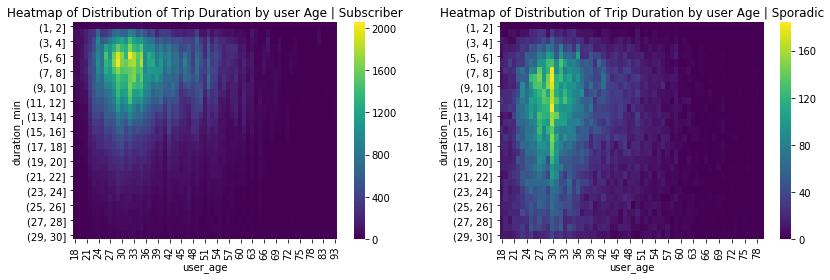

In [50]:
# Trip duration vs User age - count vs Subscriber
plt.figure(figsize=(12,4))

plt.subplot(121)
trip_duration_bins = pd.cut(subscriber1.duration_min, bins=range(0,61))
sns.heatmap(subscriber1.pivot_table(index=trip_duration_bins, columns=subscriber1.user_age, aggfunc='count',
                                fill_value=0).gender, vmin=0,cmap='viridis');
plt.title('Heatmap of Distribution of Trip Duration by user Age | Subscriber');

plt.subplot(122)
trip_duration_bins = pd.cut(subscriber0.duration_min, bins=range(0,61))
sns.heatmap(subscriber0.pivot_table(index=trip_duration_bins, columns=subscriber0.user_age, aggfunc='count',
                                fill_value=0).gender, vmin=0,cmap='viridis');
plt.title('Heatmap of Distribution of Trip Duration by user Age | Sporadic');

plt.tight_layout()

### INSIGHT
There is a clear difference in the bike usage pattern between subscribers and sporadic users:
+ **Subscribers**: 
    - the vast majority of users are between 25 and 35 years old
    - riding from 5 up to 10 minutes
    
+ **Sporadic**: 
    - the vast majority of users are between 28 and 30 years old - much more concentrated
    - riding from 7 up to 20 minutes - much more spreaded out

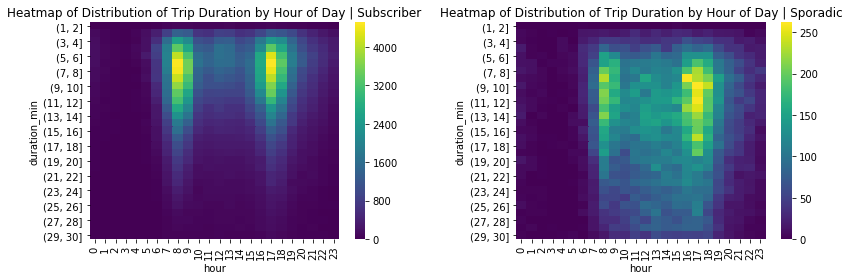

In [51]:
# Trip duration vs Hour Day - count
plt.figure(figsize=(12,4))

plt.subplot(121)
trip_duration_bins = pd.cut(subscriber1.duration_min, bins=range(0,61))
sns.heatmap(subscriber1.pivot_table(index=trip_duration_bins, columns=subscriber1.hour, aggfunc='count', fill_value=0).gender, vmin=0,
           cmap='viridis');
plt.title('Heatmap of Distribution of Trip Duration by Hour of Day | Subscriber');

plt.subplot(122)
trip_duration_bins = pd.cut(subscriber0.duration_min, bins=range(0,61))
sns.heatmap(subscriber0.pivot_table(index=trip_duration_bins, columns=subscriber0.hour, aggfunc='count', fill_value=0).gender, vmin=0,
           cmap='viridis');
plt.title('Heatmap of Distribution of Trip Duration by Hour of Day | Sporadic');

plt.tight_layout()

### INSIGHT
There is a clear difference in the bike usage pattern between subscribers and sporadic users along the hours of the day:
+ **Subscribers**: 
    - thre are two clear peaks of usage, around 8h and 17h - supporting commuting pattern
    - both peaks concentrate trips taking between 5 and 10 minutes - supporting commuting pattern
    
+ **Sporadic**: 
    - although more spread out, there is one clear peak of usage, around 17h. But significant usage starting at 8h and ending by 19h
    - although more spread out, most trips take from 7 up to 15 minutes

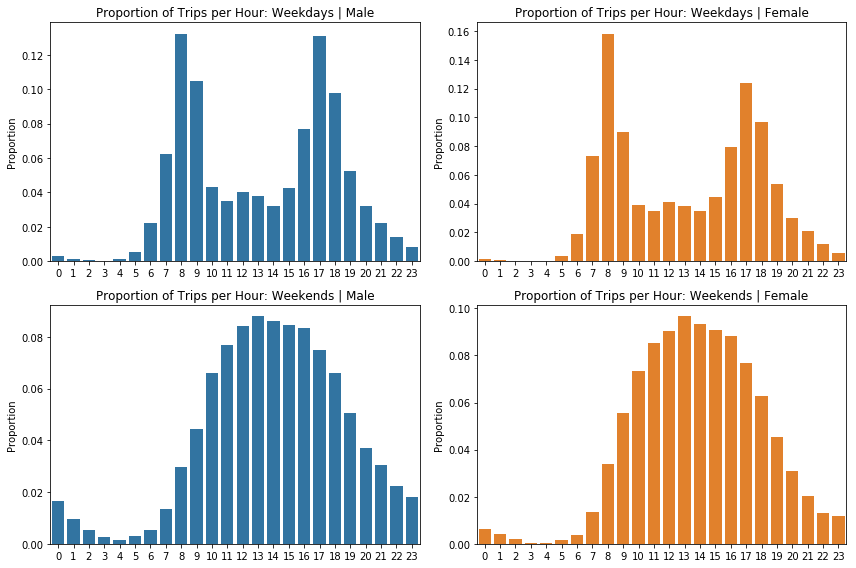

In [52]:
# Proportion of Trips per Hour of Day - stratified by Weekend and Gender
plt.figure(figsize=(12,8))

plt.subplot(221)
weekday_male = weekday.query('gender == 1')
weekday_hours_male = weekday_male.hour.value_counts(normalize=True)
sns.barplot(x= weekday_hours_male.keys(),
            y= weekday_hours_male.values, color=sns.color_palette()[0])

plt.title(f'Proportion of Trips per Hour: Weekdays | Male')
plt.ylabel('Proportion');

plt.subplot(222)
weekday_female = weekday.query('gender == 0')
weekday_hours_female = weekday_female.hour.value_counts(normalize=True)
sns.barplot(x= weekday_hours_female.keys(), y= weekday_hours_female.values, color=sns.color_palette()[1])
plt.title(f'Proportion of Trips per Hour: Weekdays | Female')
plt.ylabel('Proportion');

plt.subplot(223)
weekend_male = weekend.query('gender == 1')
weekend_hours_male = weekend_male.hour.value_counts(normalize=True)
sns.barplot(x= weekend_hours_male.keys(),
            y= weekend_hours_male.values, color=sns.color_palette()[0])
plt.title(f'Proportion of Trips per Hour: Weekends | Male')
plt.ylabel('Proportion');


plt.subplot(224)
weekend_female = weekend.query('gender == 0')
weekend_hours_female = weekend_female.hour.value_counts(normalize=True)
sns.barplot(x= weekend_hours_female.keys(),
            y= weekend_hours_female.values, color=sns.color_palette()[1])
plt.title(f'Proportion of Trips per Hour: Weekends | Female')
plt.ylabel('Proportion');

plt.tight_layout()

There is no additional insight from adding the gender dimension to the proportion of trips per hour, during weekday vs weekend. Let´s try stratifying by Subscriber status.

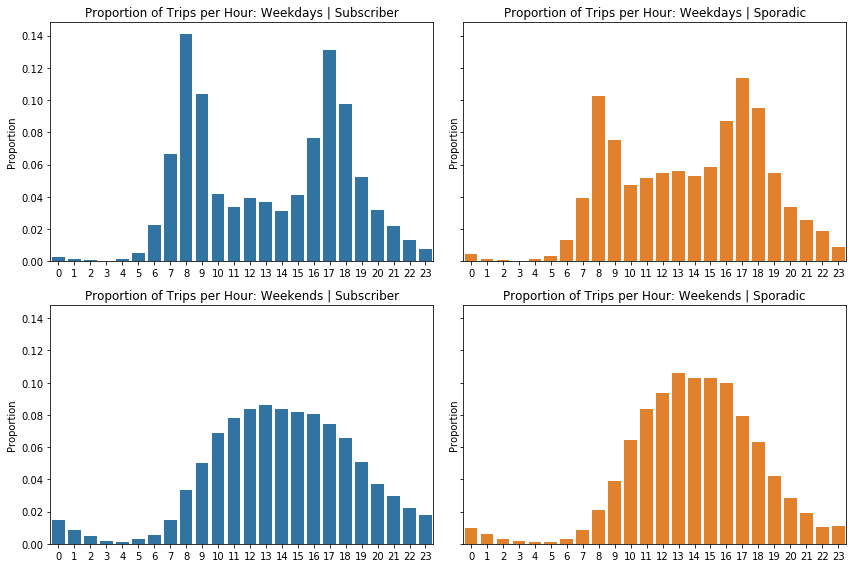

In [53]:
# Proportion of Trips per Hour of Day - stratified by Weekend and Subscriber Status
fig, axes = plt.subplots(2,2, figsize=(12,8), sharey=True)

weekday_subscriber1 = weekday.query('subscriber == 1')
weekday_hours_subscriber1 = weekday_subscriber1.hour.value_counts(normalize=True)
sns.barplot(x= weekday_hours_subscriber1.keys(),
            y= weekday_hours_subscriber1.values, color=sns.color_palette()[0], ax=axes[0,0])

axes[0,0].set_title('Proportion of Trips per Hour: Weekdays | Subscriber')
axes[0,0].set_ylabel('Proportion');


weekday_subscriber0 = weekday.query('subscriber == 0')
weekday_hours_subscriber0 = weekday_subscriber0.hour.value_counts(normalize=True)
sns.barplot(x= weekday_hours_subscriber0.keys(),
            y= weekday_hours_subscriber0.values, color=sns.color_palette()[1], ax=axes[0,1])
axes[0,1].set_title('Proportion of Trips per Hour: Weekdays | Sporadic')
axes[0,1].set_ylabel('Proportion');

weekend_subscriber1 = weekend.query('subscriber == 1')
weekend_hours_subscriber1 = weekend_subscriber1.hour.value_counts(normalize=True)
sns.barplot(x= weekend_hours_subscriber1.keys(),
            y= weekend_hours_subscriber1.values, color=sns.color_palette()[0], ax=axes[1,0])

axes[1,0].set_title('Proportion of Trips per Hour: Weekends | Subscriber')
axes[1,0].set_ylabel('Proportion');


weekend_subscriber0 = weekend.query('subscriber == 0')
weekend_hours_subscriber0 = weekend_subscriber0.hour.value_counts(normalize=True)
sns.barplot(x= weekend_hours_subscriber0.keys(),
            y= weekend_hours_subscriber0.values, color=sns.color_palette()[1], ax=axes[1,1])
axes[1,1].set_title('Proportion of Trips per Hour: Weekends | Sporadic')
axes[1,1].set_ylabel('Proportion');

plt.tight_layout()

### INSIGHT
As identified before, there is indeed a clear difference in usage pattern between Subscribers and Sporadic users, specially during weekdays:
+ Subscribers: typical commuting pattern during weekdays, where the vast majority of trips are concentrated in two peaks, around 8h and 17h
+ Sporadic: although there are two peaks around 8h and 17h, they are not as accentuated as with the subscribers, having a higher proportion of trips almost uniformly distributed between 10h and 15h.

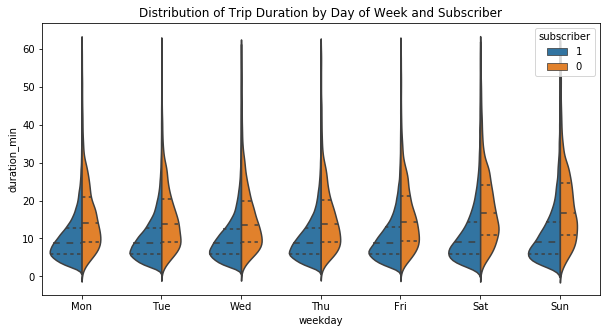

In [54]:
# Trip Duration vs Weekday vs Subscriber
plt.figure(figsize=(10,5))

sns.violinplot(data=df, y='duration_min', x='weekday', hue='subscriber', split=True, orient='v', inner='quartile',
              hue_order=[1,0]);
plt.title('Distribution of Trip Duration by Day of Week and Subscriber');
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

### INSIGHT
It is clear to see a difference in the bike usage pattern between subscribers and sporadic users, where the former typically take shorter trips. Just as seen before, weekday trips are shorter and concentrated around 10 minutes, whereas weekend trips are longer and more spread out - for both types of users.

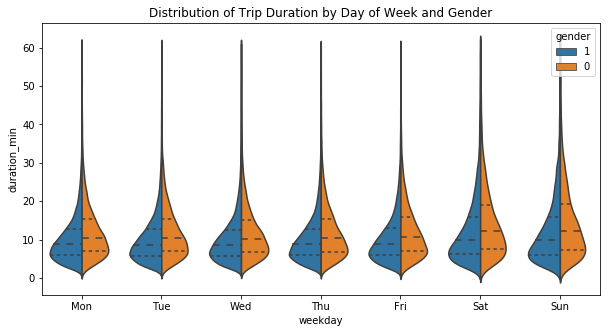

In [55]:
# Trip Duration vs Weekday vs Gender
plt.figure(figsize=(10,5))

sns.violinplot(data=df, y='duration_min', x='weekday', hue='gender', split=True, orient='v', inner='quartile',
              hue_order=[1,0]);
plt.title('Distribution of Trip Duration by Day of Week and Gender');
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

As seen before, there is no significant influence of gender on duration of trips. Weekday trips are shorter and concentrated aorund 10 minutes, suggesting commute usage. Whereas weekend trips are more spread out. 

No significant contribution to the previous bi-variate analysis.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

Unfortunately, there were no significant contributions from the multi-variate analysis. They basically just supported the insights identified in the bi-variate visualizations. The main interesting relationships were: 1)Trip Duration and User Age, and 2) Trip DUration and Hour of Day, influenced by A)Subscriber status and B)Weekday/Weekend.

### Were there any interesting or surprising interactions between features?

+ Gender does not seem to significantly influence any attribute, be it trip duration, user age, or hour of usage.

+ Also, it was not possible to identify a clear correlation between user age and trip duration, suggesting the physical effort of riding a bike is not a limiting factor.